In [5]:
# =============================================================================
# 1. KHAI BÁO THƯ VIỆN & CẤU HÌNH
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import warnings
import shap

# NLP Libraries
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Sklearn & Metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# XGBoost & Imbalance Handling
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

# Cấu hình
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
# Đảm bảo hiển thị tiếng Việt/ký tự đặc biệt tốt hơn trong đồ thị
plt.rcParams.update({'font.size': 12})

print("✅ Đã tải xong các thư viện cần thiết.")

✅ Đã tải xong các thư viện cần thiết.


In [6]:
# =============================================================================
# 2. TẢI DỮ LIỆU VÀ CHUẨN BỊ
# =============================================================================
import os

print("--- [BƯỚC 1] Tải dữ liệu đã xử lý ---")

# 1. Xác định vị trí folder dataframes
if os.path.exists('dataframes'):
    DATA_PATH = 'dataframes'
    print(f"✅ Đã tìm thấy thư mục dữ liệu tại: ./{DATA_PATH}")
elif os.path.exists('../dataframes'):
    DATA_PATH = '../dataframes'
    print(f"✅ Đã tìm thấy thư mục dữ liệu tại: {DATA_PATH} (Thư mục cha)")
else:
    # Nếu không tìm thấy, báo lỗi và dừng lại
    raise FileNotFoundError("❌ LỖI: Không tìm thấy folder 'dataframes'. Hãy chắc chắn nó nằm cùng cấp hoặc ngay bên ngoài folder 'final'.")

# 2. Tải dữ liệu bằng đường dẫn động
try:
    # Dùng os.path.join để nối đường dẫn an toàn trên mọi hệ điều hành
    df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_data.csv'))
    df_val = pd.read_csv(os.path.join(DATA_PATH, 'val_data.csv')) 
    df_test = pd.read_csv(os.path.join(DATA_PATH, 'test_data.csv'))

    y_train = pd.read_csv(os.path.join(DATA_PATH, 'y_train.csv'))['label']
    y_test = pd.read_csv(os.path.join(DATA_PATH, 'y_test.csv'))['label']
    
    print("Dữ liệu đã tải thành công.")
except Exception as e:
    print(f"❌ LỖI CHI TIẾT: {e}")

# Loại bỏ giá trị Null (nếu có)
corpus_train = df_train['text'].dropna()
corpus_test = df_test['text'].dropna()

# Mã hóa nhãn (Label Encoding)
print("\n--- [BƯỚC 2] Mã hóa nhãn ---")
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

class_names = list(le.classes_)
print(f"Các lớp mục tiêu: {class_names}")
print(f"Số lượng mẫu Train: {len(corpus_train)}")
print(f"Số lượng mẫu Test:  {len(corpus_test)}")

--- [BƯỚC 1] Tải dữ liệu đã xử lý ---
✅ Đã tìm thấy thư mục dữ liệu tại: ../dataframes (Thư mục cha)
Dữ liệu đã tải thành công.

--- [BƯỚC 2] Mã hóa nhãn ---
Các lớp mục tiêu: ['A1', 'A2', 'B1', 'B2']
Số lượng mẫu Train: 1260
Số lượng mẫu Test:  361


In [7]:
# =============================================================================
# 3. VECTOR HÓA DỮ LIỆU (WORD2VEC)
# =============================================================================
print("--- [BƯỚC 3] Xây dựng đặc trưng bằng Word2Vec ---")

# 1. Tokenize
tokenized_corpus = [word_tokenize(doc) for doc in corpus_train]

# 2. Huấn luyện mô hình Word2Vec
W2V_SIZE = 300
print(f"Đang huấn luyện Word2Vec (Size={W2V_SIZE})...")

w2v_model = Word2Vec(
    sentences=tokenized_corpus, 
    vector_size=W2V_SIZE, 
    window=5, 
    min_count=5, 
    workers=4,
    seed=42
)
w2v_vocab = set(w2v_model.wv.index_to_key)

# 3. Hàm biến đổi văn bản thành vector trung bình
def get_document_vector(doc):
    tokens = word_tokenize(doc)
    valid_tokens = [word for word in tokens if word in w2v_vocab]
    if not valid_tokens:
        return np.zeros(W2V_SIZE)
    return np.mean([w2v_model.wv[word] for word in valid_tokens], axis=0)

# 4. Áp dụng vector hóa cho Train và Test
print("Đang vector hóa tập Train và Test...")
X_train_vec = np.array([get_document_vector(doc) for doc in corpus_train])
X_test_vec = np.array([get_document_vector(doc) for doc in corpus_test])

print(f"Kích thước X_train: {X_train_vec.shape}")
print(f"Kích thước X_test:  {X_test_vec.shape}")

--- [BƯỚC 3] Xây dựng đặc trưng bằng Word2Vec ---
Đang huấn luyện Word2Vec (Size=300)...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Đang vector hóa tập Train và Test...
Kích thước X_train: (1260, 300)
Kích thước X_test:  (361, 300)


In [8]:
# =============================================================================
# 4. XỬ LÝ MẤT CÂN BẰNG (SMOTE)
# =============================================================================
print("--- [BƯỚC 4] Cân bằng dữ liệu với SMOTE ---")
print(f"Phân bố lớp trước SMOTE: {Counter(y_train_encoded)}")

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train_encoded)

print(f"Phân bố lớp sau SMOTE:   {Counter(y_train_res)}")
print("✅ Dữ liệu đã được cân bằng.")

--- [BƯỚC 4] Cân bằng dữ liệu với SMOTE ---
Phân bố lớp trước SMOTE: Counter({np.int64(0): 705, np.int64(1): 212, np.int64(3): 200, np.int64(2): 143})
Phân bố lớp sau SMOTE:   Counter({np.int64(0): 705, np.int64(3): 705, np.int64(2): 705, np.int64(1): 705})
✅ Dữ liệu đã được cân bằng.


In [9]:
# =============================================================================
# 5. HUẤN LUYỆN MÔ HÌNH (FINAL MODEL)
# =============================================================================
print("--- [BƯỚC 5] Huấn luyện Mô hình XGBoost ---")

# Cấu hình
final_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    objective='multi:softmax',
    num_class=len(class_names),
    n_jobs=-1,
    random_state=42
)

start_time = time.time()
final_model.fit(X_train_res, y_train_res)
end_time = time.time()

print(f"Huấn luyện hoàn tất sau {end_time - start_time:.2f} giây.")

# Lưu mô hình
joblib.dump(final_model, 'final_model.pkl')
print("Đã lưu mô hình vào 'final_model.pkl'")

--- [BƯỚC 5] Huấn luyện Mô hình XGBoost ---
Huấn luyện hoàn tất sau 9.02 giây.
Đã lưu mô hình vào 'final_model.pkl'


--- [BƯỚC 6] Đánh giá trên tập Test Độc lập ---

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

          A1       0.89      0.87      0.88       202
          A2       0.57      0.59      0.58        61
          B1       0.38      0.41      0.40        41
          B2       0.64      0.63      0.64        57

    accuracy                           0.73       361
   macro avg       0.62      0.63      0.62       361
weighted avg       0.74      0.73      0.73       361


=== CONFUSION MATRIX ===


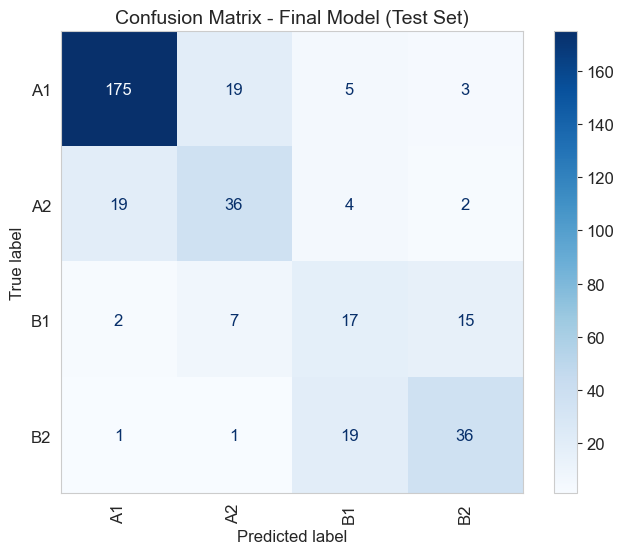

In [10]:
# =============================================================================
# 6. ĐÁNH GIÁ HIỆU SUẤT (EVALUATION)
# =============================================================================
print("--- [BƯỚC 6] Đánh giá trên tập Test Độc lập ---")

# Dự đoán
y_pred = final_model.predict(X_test_vec)

# 1. Báo cáo phân loại
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test_encoded, y_pred, target_names=class_names))

# 2. Ma trận nhầm lẫn
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical', values_format='d')
plt.title("Confusion Matrix - Final Model (Test Set)", fontsize=14)
plt.grid(False)
plt.show()

--- [BƯỚC 7] Phân tích SHAP (XAI) ---
1. Kích thước dữ liệu đầu vào (X_test_sample): (200, 300)
2. Đang tính toán giá trị SHAP...
   -> Dạng dữ liệu gốc: 3D Array (200, 300, 4)
   -> Đang chuyển đổi sang List các lớp...
4. Đang kiểm tra kích thước cột...
   -> Kích thước sau khi xử lý (Lớp đầu tiên): (200, 300)

5. Đang vẽ biểu đồ...


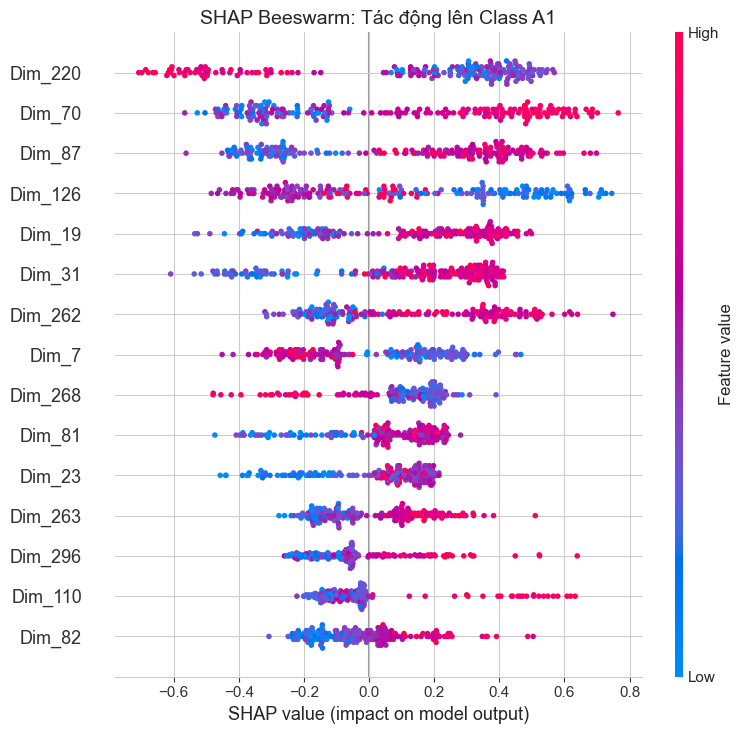

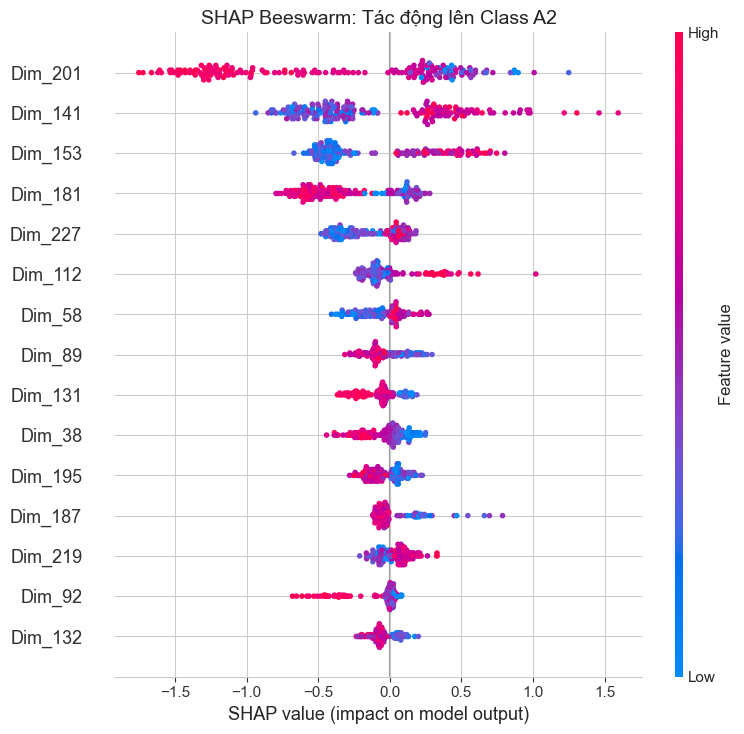

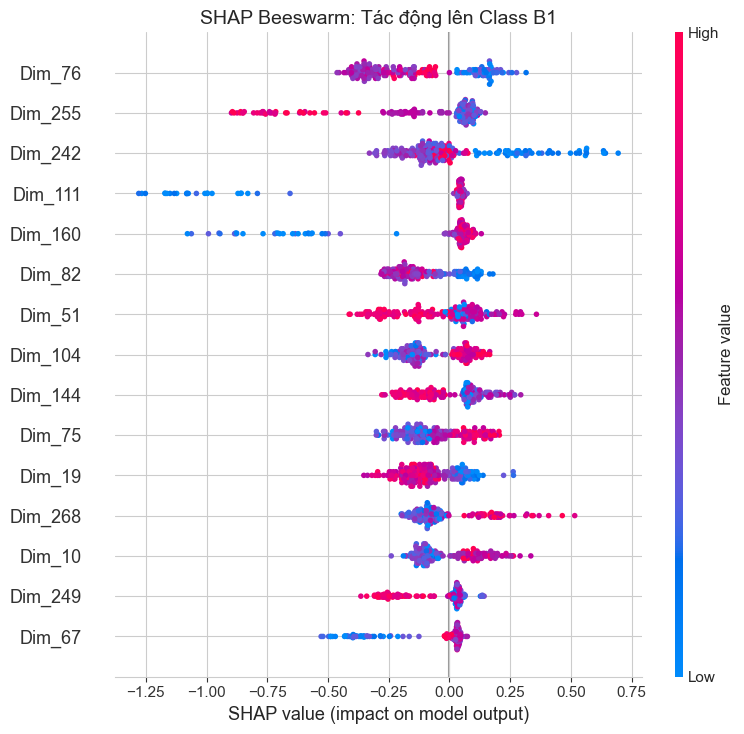

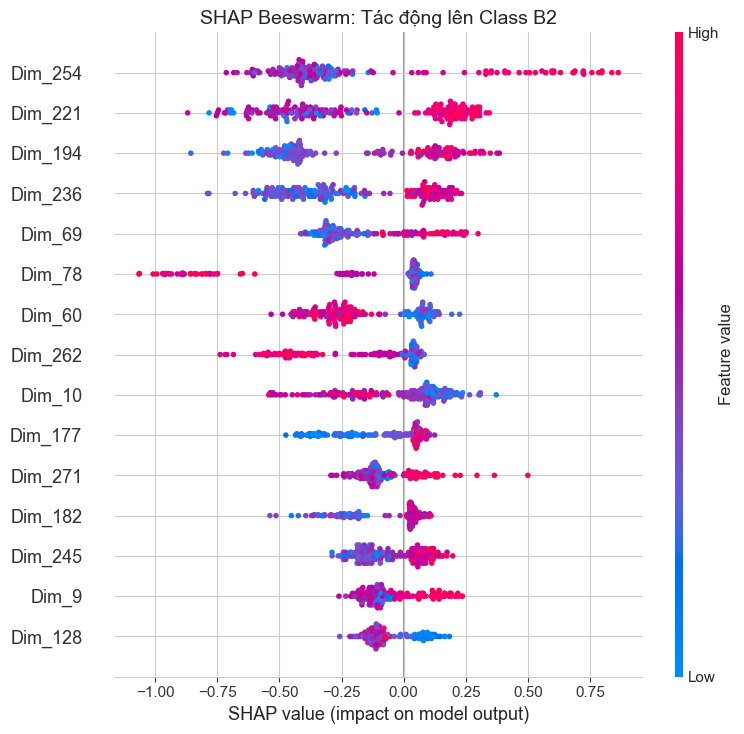

Đang vẽ Bar Plot tổng quan...


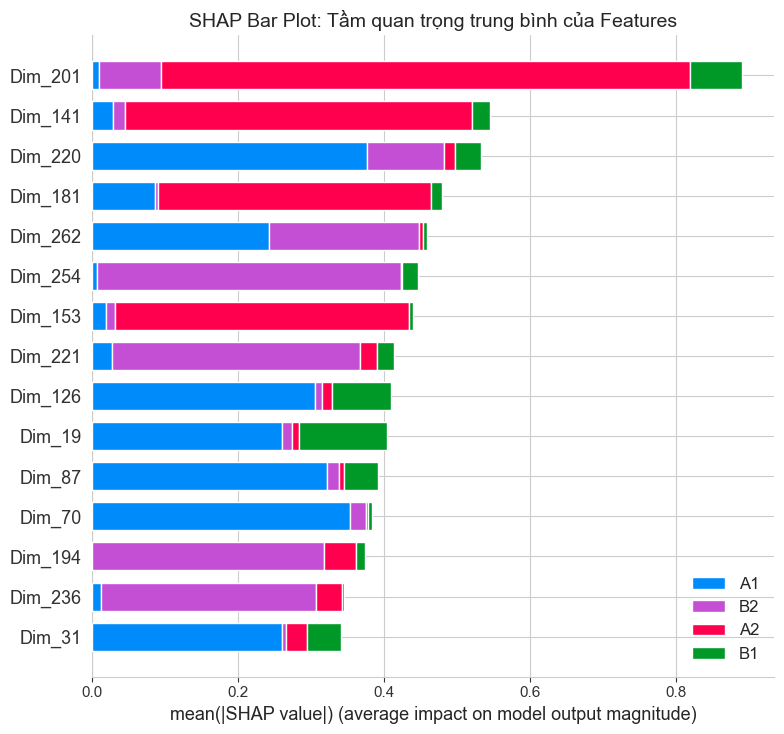


✅ HOÀN TẤT PHÂN TÍCH SHAP


In [18]:
# =============================================================================
# 7. GIẢI THÍCH MÔ HÌNH (SHAP ANALYSIS)
# =============================================================================
print("--- [BƯỚC 7] Phân tích SHAP (XAI) ---")

# 1. Lấy mẫu dữ liệu
np.random.seed(42)
indices = np.random.choice(X_test_vec.shape[0], 200, replace=False)
X_test_sample = X_test_vec[indices]

print(f"1. Kích thước dữ liệu đầu vào (X_test_sample): {X_test_sample.shape}")

# 2. Tính toán SHAP
print("2. Đang tính toán giá trị SHAP...")
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_sample)

# 3. CHUẨN HÓA CẤU TRÚC SHAP VALUES (QUAN TRỌNG)
# Chuyển đổi mọi định dạng về List các ma trận 2D [ (N, M), (N, M), ... ]
processed_shap_values = []

# Kiểm tra xem kết quả là List hay Array
if isinstance(shap_values, list):
    print("   -> Dạng dữ liệu gốc: List (Chuẩn cũ)")
    processed_shap_values = shap_values
elif len(np.array(shap_values).shape) == 3:
    print(f"   -> Dạng dữ liệu gốc: 3D Array {np.array(shap_values).shape}")
    print("   -> Đang chuyển đổi sang List các lớp...")
    # Chuyển từ (N, M, C) -> List of (N, M)
    num_classes = shap_values.shape[2]
    processed_shap_values = [shap_values[:, :, i] for i in range(num_classes)]
else:
    print("   -> Dạng dữ liệu gốc: 2D Array (Binary classification?)")
    processed_shap_values = [shap_values]

# 4. KIỂM TRA VÀ CẮT CỘT THỪA
final_shap_values = []
print("4. Đang kiểm tra kích thước cột...")
for i, sv in enumerate(processed_shap_values):
    if sv.shape[1] > W2V_SIZE:
        sv_fixed = sv[:, :W2V_SIZE]
        final_shap_values.append(sv_fixed)
    else:
        final_shap_values.append(sv)

print(f"   -> Kích thước sau khi xử lý (Lớp đầu tiên): {final_shap_values[0].shape}")

# 5. VẼ BIỂU ĐỒ
print("\n5. Đang vẽ biểu đồ...")
display_class_names = [f"Class {name}" for name in class_names]

# --- BEESWARM PLOT (Vẽ cho từng lớp) ---
for i, class_name in enumerate(display_class_names):
    if i >= len(final_shap_values): break
    
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        final_shap_values[i], 
        X_test_sample, 
        feature_names=[f"Dim_{j}" for j in range(W2V_SIZE)],
        max_display=15,
        show=False      
    )
    plt.title(f"SHAP Beeswarm: Tác động lên {class_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

# --- BAR PLOT (Tổng quan) ---
print("Đang vẽ Bar Plot tổng quan...")
plt.figure(figsize=(10, 6))
shap.summary_plot(
    final_shap_values, 
    X_test_sample, 
    plot_type="bar", 
    class_names=class_names,
    feature_names=[f"Dim_{j}" for j in range(W2V_SIZE)],
    max_display=15,
    show=False
)
plt.title("SHAP Bar Plot: Tầm quan trọng trung bình của Features", fontsize=14)
plt.tight_layout()
plt.show()

print("\n✅ HOÀN TẤT PHÂN TÍCH SHAP")

--- [BƯỚC 8] Phân tích Case Study (Local Interpretation) ---


Đang tạo dự đoán cho tập Test...
✅ Số lượng mẫu dự đoán SAI: 97
✅ Số lượng mẫu dự đoán ĐÚNG: 264

🧐 CASE 1: MÔ HÌNH DỰ ĐOÁN SAI
🏷️ Nhãn THỰC TẾ: A1
🤖 Nhãn DỰ ĐOÁN: B2
📊 Giải thích: Tại sao mô hình chọn lớp 'B2'?


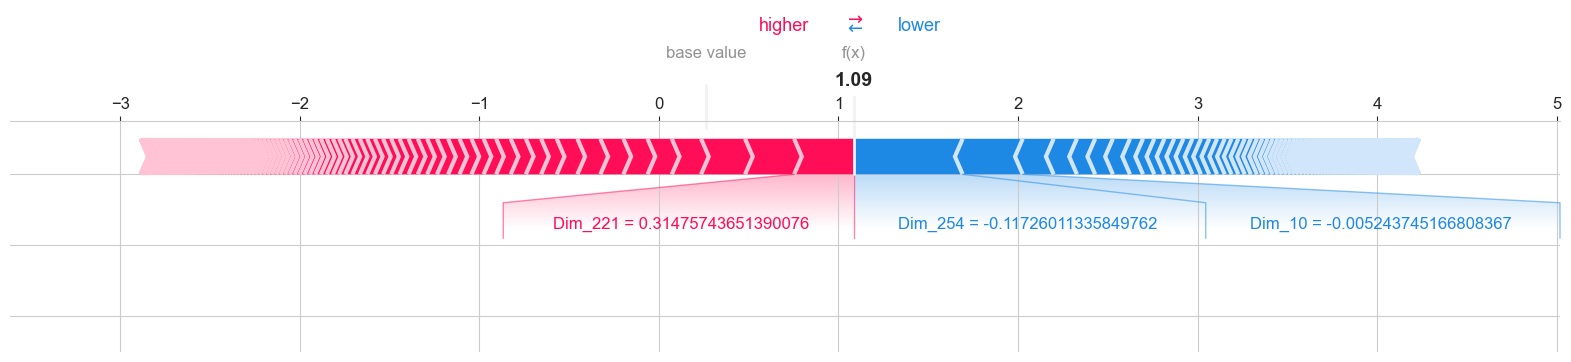


🧐 CASE 2: MÔ HÌNH DỰ ĐOÁN ĐÚNG
🏷️ Nhãn THỰC TẾ: B1
🤖 Nhãn DỰ ĐOÁN: B1
📊 Giải thích: Tại sao mô hình chọn lớp 'B1'?


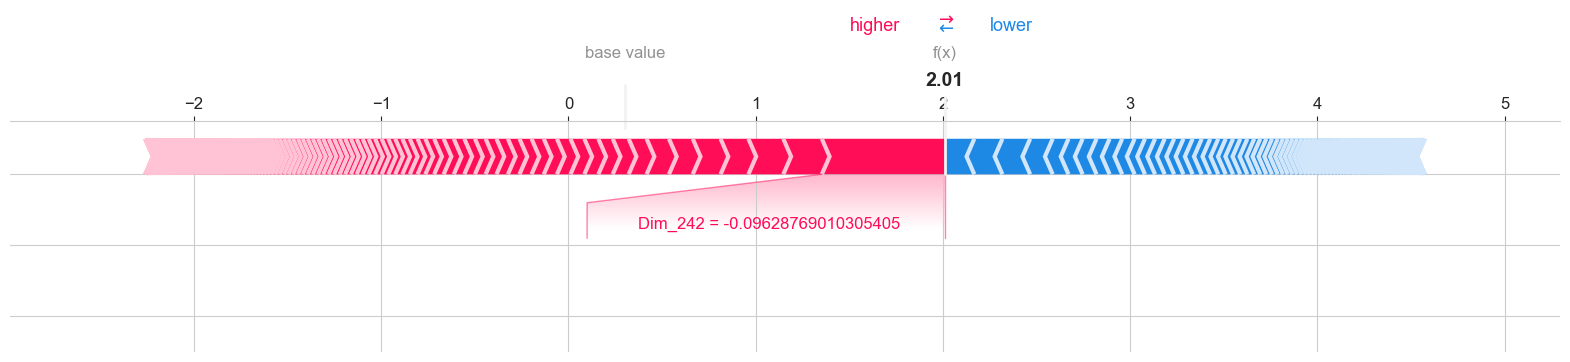

In [ ]:
# =============================================================================
# 8. CASE STUDY: PHÂN TÍCH CHI TIẾT TỪNG MẪU (LOCAL INTERPRETATION)
# =============================================================================
print("--- [BƯỚC 8] Phân tích Case Study (Local Interpretation) ---")

# 0. KHỞI TẠO & CHUẨN BỊ DỮ LIỆU
shap.initjs() 

# Xác định biến vector test hiện có (X_test_vec hay X_test_w2v?)
if 'X_test_vec' in locals():
    X_test_current = X_test_vec
elif 'X_test_w2v' in locals():
    X_test_current = X_test_w2v
else:
    raise ValueError("❌ Lỗi: Không tìm thấy dữ liệu Test (X_test_vec hoặc X_test_w2v). Hãy chạy Bước 3 trước.")

# Tự động dự đoán lại để có biến y_pred_test
print("Đang tạo dự đoán cho tập Test...")
y_pred_test = final_model.predict(X_test_current)

# 1. TÌM KIẾM CÁC CHỈ SỐ (INDICES)
df_analysis = pd.DataFrame({
    'True_Label_Index': y_test_encoded,
    'Pred_Label_Index': y_pred_test,
    'True_Label': le.inverse_transform(y_test_encoded),
    'Pred_Label': le.inverse_transform(y_pred_test)
})

# Tách các trường hợp Đúng (TP) và Sai (FN)
false_negatives = df_analysis[df_analysis['True_Label_Index'] != df_analysis['Pred_Label_Index']]
true_positives = df_analysis[df_analysis['True_Label_Index'] == df_analysis['Pred_Label_Index']]

print(f"✅ Số lượng mẫu dự đoán SAI: {len(false_negatives)}")
print(f"✅ Số lượng mẫu dự đoán ĐÚNG: {len(true_positives)}")

# --- HÀM VẼ FORCE PLOT ---
def plot_case_study(sample_index, case_type="Case Study"):
    # Lấy vector của mẫu này
    sample_vec = X_test_current[sample_index].reshape(1, -1)
    
    # Tính giá trị SHAP
    shap_values_single = explainer.shap_values(sample_vec)
    
    # Lấy thông tin nhãn
    true_label_idx = y_test_encoded[sample_index]
    pred_label_idx = y_pred_test[sample_index]
    true_label_name = class_names[true_label_idx]
    pred_label_name = class_names[pred_label_idx]
    
    target_class_idx = pred_label_idx
    target_class_name = class_names[target_class_idx]
    
    print("\n" + "="*60)
    print(f"🧐 {case_type}")
    print("="*60)
    print(f"🏷️ Nhãn THỰC TẾ: {true_label_name}")
    print(f"🤖 Nhãn DỰ ĐOÁN: {pred_label_name}")
    print(f"📊 Giải thích: Tại sao mô hình chọn lớp '{target_class_name}'?")
    
    # --- LOGIC XỬ LÝ MẢNG ---
    # 1. Base Value
    base_val = explainer.expected_value
    if isinstance(base_val, list) or isinstance(base_val, np.ndarray):
        val_base = base_val[target_class_idx]
    else:
        val_base = base_val
        
    # 2. SHAP Values (Xử lý 3D Array vs List)
    if isinstance(shap_values_single, list):
        vals = shap_values_single[target_class_idx][0]
    elif len(np.array(shap_values_single).shape) == 3:
        # (1, 300, 4) -> Lấy mẫu 0, tất cả feature, lớp target
        vals = shap_values_single[0, :, target_class_idx]
    else:
        vals = shap_values_single[0]

    # 3. Cắt cột thừa
    if len(vals) > W2V_SIZE:
        vals = vals[:W2V_SIZE]

    return shap.force_plot(
        val_base,
        vals,
        sample_vec[0],
        feature_names=[f"Dim_{i}" for i in range(W2V_SIZE)],
        matplotlib=True,
        show=False
    )

# --- CHẠY CASE STUDY ---

# Case 1: Dự đoán SAI
if len(false_negatives) > 0:
    idx_fn_dataframe = false_negatives.index[0] 
    idx_fn_real = df_analysis.index.get_loc(idx_fn_dataframe)
    
    plot_case_study(idx_fn_real, case_type="CASE 1: MÔ HÌNH DỰ ĐOÁN SAI")
    plt.show()

# Case 2: Dự đoán ĐÚNG
b1_indices = true_positives[true_positives['True_Label'] == 'B1']
if len(b1_indices) > 0:
    idx_tp_dataframe = b1_indices.index[0]
else:
    idx_tp_dataframe = true_positives.index[0]

idx_tp_real = df_analysis.index.get_loc(idx_tp_dataframe)
plot_case_study(idx_tp_real, case_type="CASE 2: MÔ HÌNH DỰ ĐOÁN ĐÚNG")
plt.show()